# Introduction
In this notebook we'll see how to detect fall occurance using the **Smartphone Human Fall Dataset**. This notebook will cover the following topics:
* *Data visualization* using standard matploitlib and seaborn library.
* *Feature Selection* using **Mutual Information** score.
* *Classification* using **Random Forest Classifier**.
* *Hyperparameter optimization* using **Random Search**.

The notebook is divided into 5 sections:
1. Importing Necessary Libraries.
2. Loading the Datasets.
3. Similarity Measure and Feature Selection.
4. Feature Normalization
5. Hyperparameter Tuning of Random Forest using Random Search and Grid Search

# 1. Importing Necessary Libraries


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import warnings
import os
import random
%matplotlib inline
random.seed(42)
plt.rcParams.update({'font.size': 25})
sns.set_theme(color_codes=True)
warnings.filterwarnings('ignore')
print("CHKPoint 001")
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

CHKPoint 001


# 2. Loading the Datasets

We load the train and test csv files in pandas dataframes.

In [11]:
train_df = pd.read_csv("./input/Train.csv")
test_df = pd.read_csv('./input/Test.csv')

Lets take a peek at our data.

In [12]:
train_df.head()

,Unnamed: 0,acc_max,gyro_max,acc_kurtosis,gyro_kurtosis,label,lin_max,acc_skewness,gyro_skewness,post_gyro_max,post_lin_max,fall
0,661,26.039919,7.309797,20.378162,2.782476,SDL,11.131080,3.891361,1.592927,7.086618,10.790400,1
1,122,25.864500,6.511954,14.187190,5.324864,FOL,7.945561,3.022175,2.376939,6.325522,7.719352,1
2,113,27.524501,12.944099,31.855926,22.891186,FOL,14.454818,4.849024,4.283890,12.888111,14.368784,1
3,14,30.647705,11.694868,23.608764,9.287735,FOL,15.228303,3.921537,2.794609,11.549971,14.944151,1
4,529,26.373917,11.168424,14.318453,15.983202,FKL,10.007396,3.087975,3.363557,11.057636,9.753058,1


In [13]:
test_df.head()

,Unnamed: 0,acc_max,gyro_max,acc_kurtosis,gyro_kurtosis,label,lin_max,acc_skewness,gyro_skewness,post_gyro_max,post_lin_max,fall
0,9,28.055199,10.794617,21.334536,34.163811,FOL,13.880578,3.283404,4.577283,10.755339,13.762561,1
1,11,26.639681,8.785024,13.518671,12.812894,FOL,15.789372,3.301849,3.464729,8.277714,15.341656,1
2,19,25.045219,5.307413,21.603060,4.754182,FOL,11.592445,3.124714,2.268676,4.976134,11.303823,1
3,23,24.102184,8.929061,24.647657,18.595684,FOL,10.107835,4.522305,3.955288,8.719755,9.727437,1
4,28,31.668808,10.714750,18.008912,15.086251,FOL,14.138265,3.142132,3.530621,10.580791,13.935016,1


The *Unnamed: 0* column in the dataframes is unnecessary, lets drop it.

In [14]:
train_df.drop(['Unnamed: 0'], axis = 1, inplace = True)
test_df.drop(['Unnamed: 0'], axis = 1, inplace = True)

Now lets look at the shape of our data.

In [15]:
print(f"Training data shape: {train_df.shape}\nTest data shape: {test_df.shape}")

Training data shape: (1428, 11)
Test data shape: (356, 11)


Now we split the train, test feature and target data into seperate dataframes.

In [16]:
X_train = train_df.drop(['fall','label'],axis=1)
y_train = train_df['fall']
X_test =  test_df.drop(['fall','label'],axis=1)
y_test =  test_df['fall']

# 3. Similarity Measure and Feature Selection

For feature selection we'll use the **Mutual Information scores**. Mutual information measures the similarity between each of the features and the target variable.

In [17]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y, discrete_features=False)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X_train, y_train)

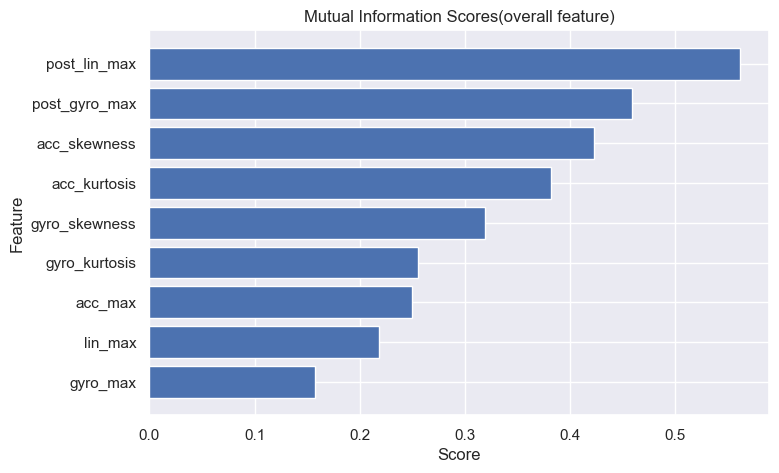

In [18]:
def plot_utility_scores(scores):
    y = scores.sort_values(ascending=True)
    width = np.arange(len(y))
    ticks = list(y.index)
    plt.barh(width, y)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores(overall feature)")

plt.figure(dpi=100, figsize=(8, 5))
plt.xlabel("Score")
plt.ylabel("Feature")
plot_utility_scores(mi_scores)

### Observations:
* We can see from the above plot that **post_lin_max** and **post_gyro_max** has the highest similarity with the target *fall*. This is because after a *fall* event occurs the linear and gyroscope magnitude falls near zero as the person's momentum changes abruptly.

* **gyro_max** has the least similarity with the target *fall* which is less than 0.2.


Let us also plot a heatmap to understand the correlation between different features and the target.

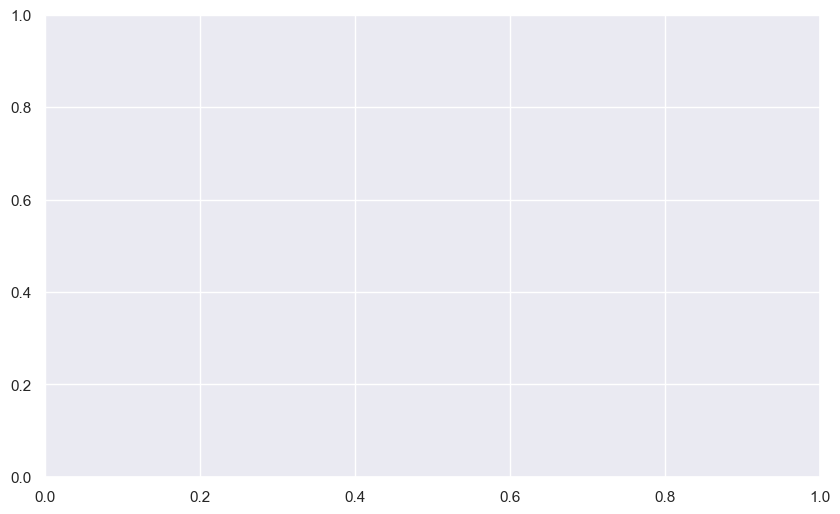

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

### Observations:
* **post_lin_max** and **post_gyro_max** has high positive correlation with the target *fall* which is 0.86 and 0.76.
* **gyro_max** has the lowest correlation with the target which is 0.47,all the rest of the features have a positive correlation greater than 0.5 with the target.

### Conclusion:
* We will drop the feature **gyro_max** as it is not much similar to our target vector and is less significant in prediction.

In [22]:
# mask = np.zeros((1428, 11))
# mask[:,4] = True
sns.heatmap(train_df.corr(numeric_only = True), ax=ax,  cmap="Blues", annot=True)

<Axes: >

In [23]:
X_train.drop(['gyro_max'], axis=1, inplace=True)
X_test.drop(['gyro_max'], axis=1, inplace=True)

Now let us look at how post_lin_max and post_gyro_max creates a distinction between *fall* events and *non fall* events.

<Axes: xlabel='label', ylabel='post_gyro_max'>

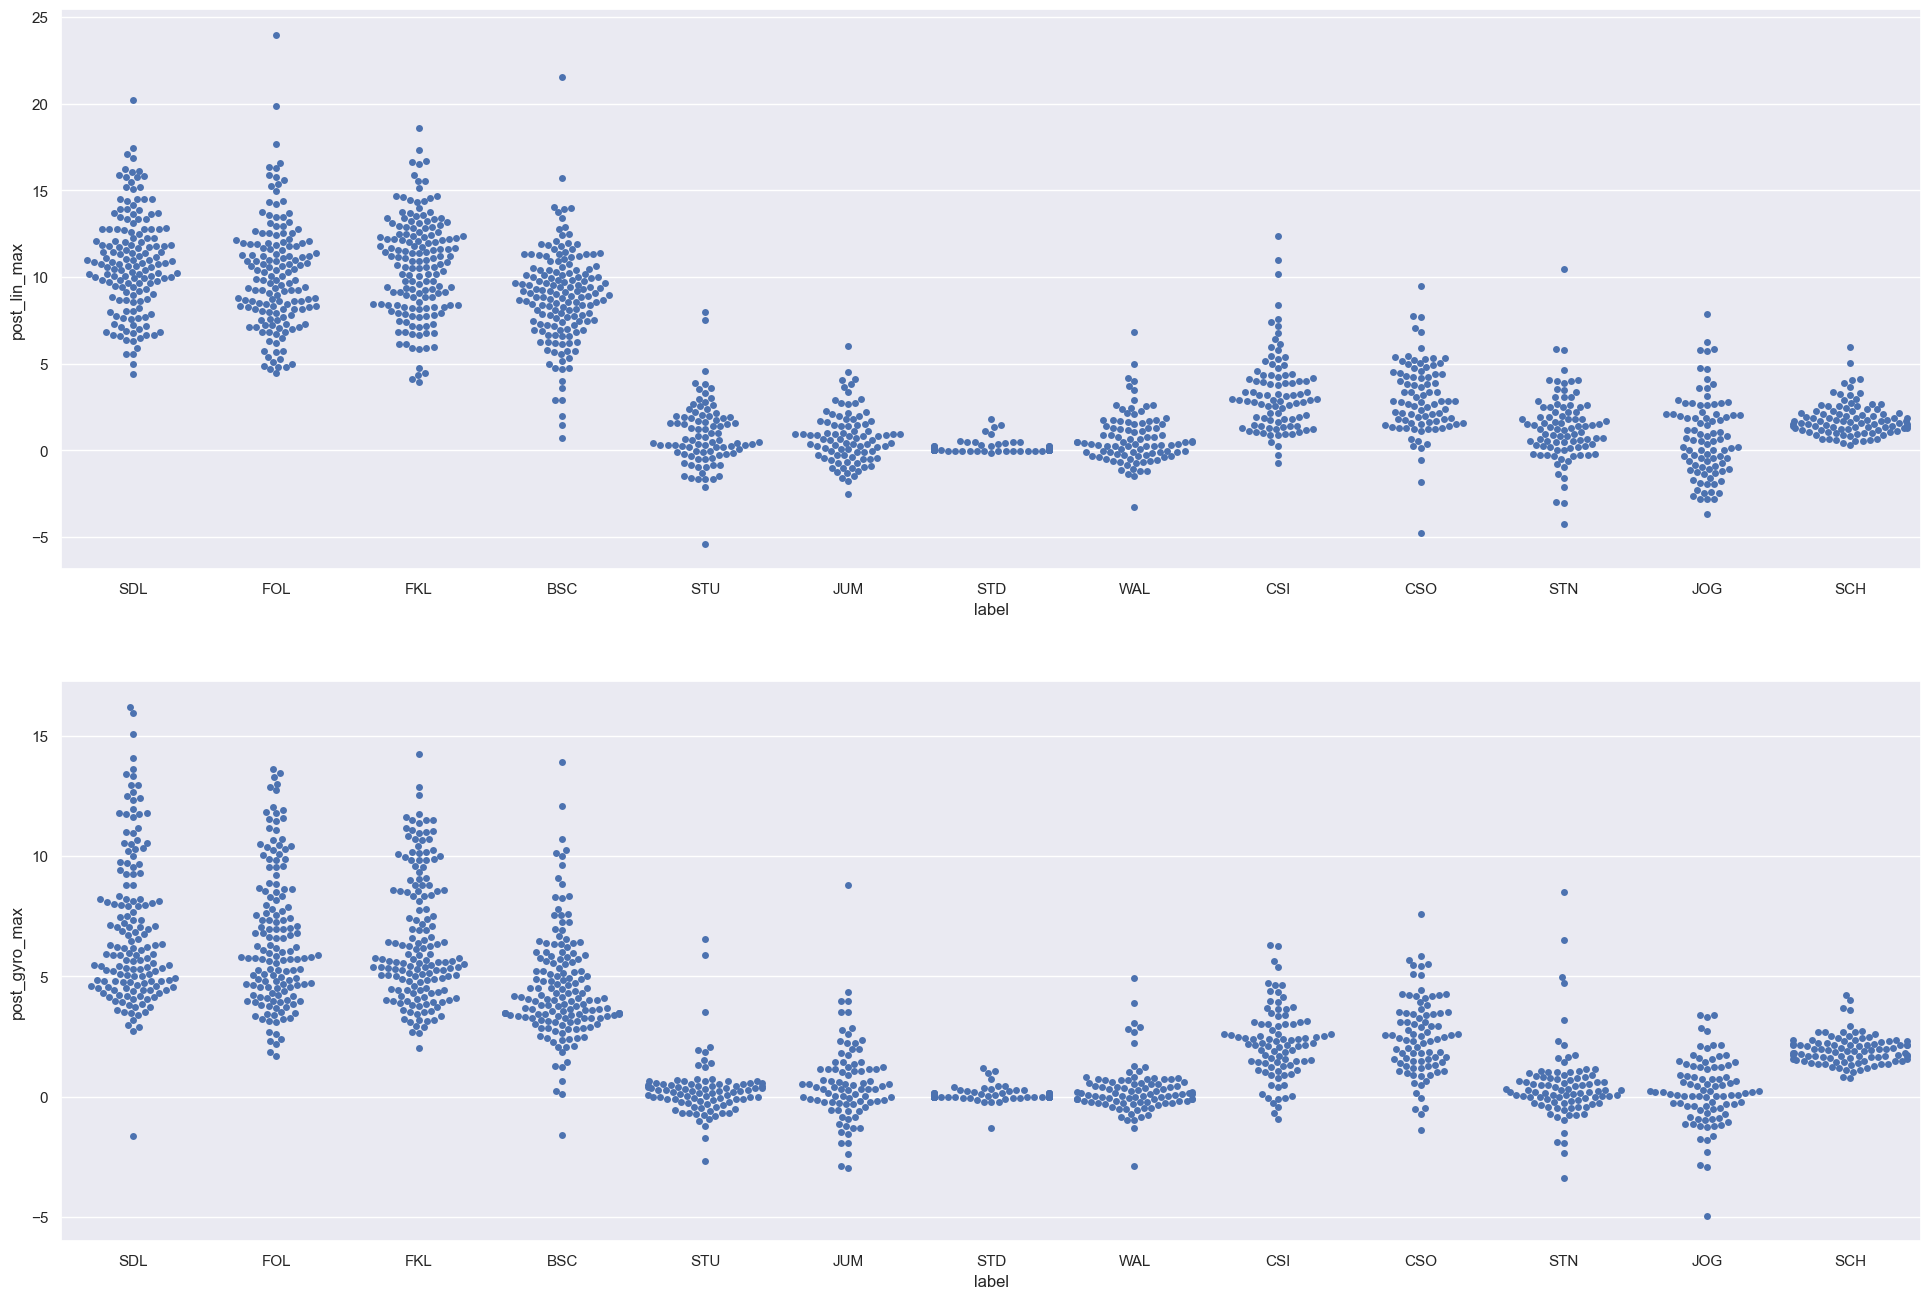

In [24]:
figure, ax = plt.subplots(2, figsize=(24, 16))

sns.swarmplot(x = train_df.label,y = train_df.post_lin_max, ax = ax[0])
sns.swarmplot(x = train_df.label,y = train_df.post_gyro_max, ax = ax[1])

SDL, FOL, FKL and BSC are *fall* events.

# 4. Feature Normalization
Let us look at the distribution of each of the features.

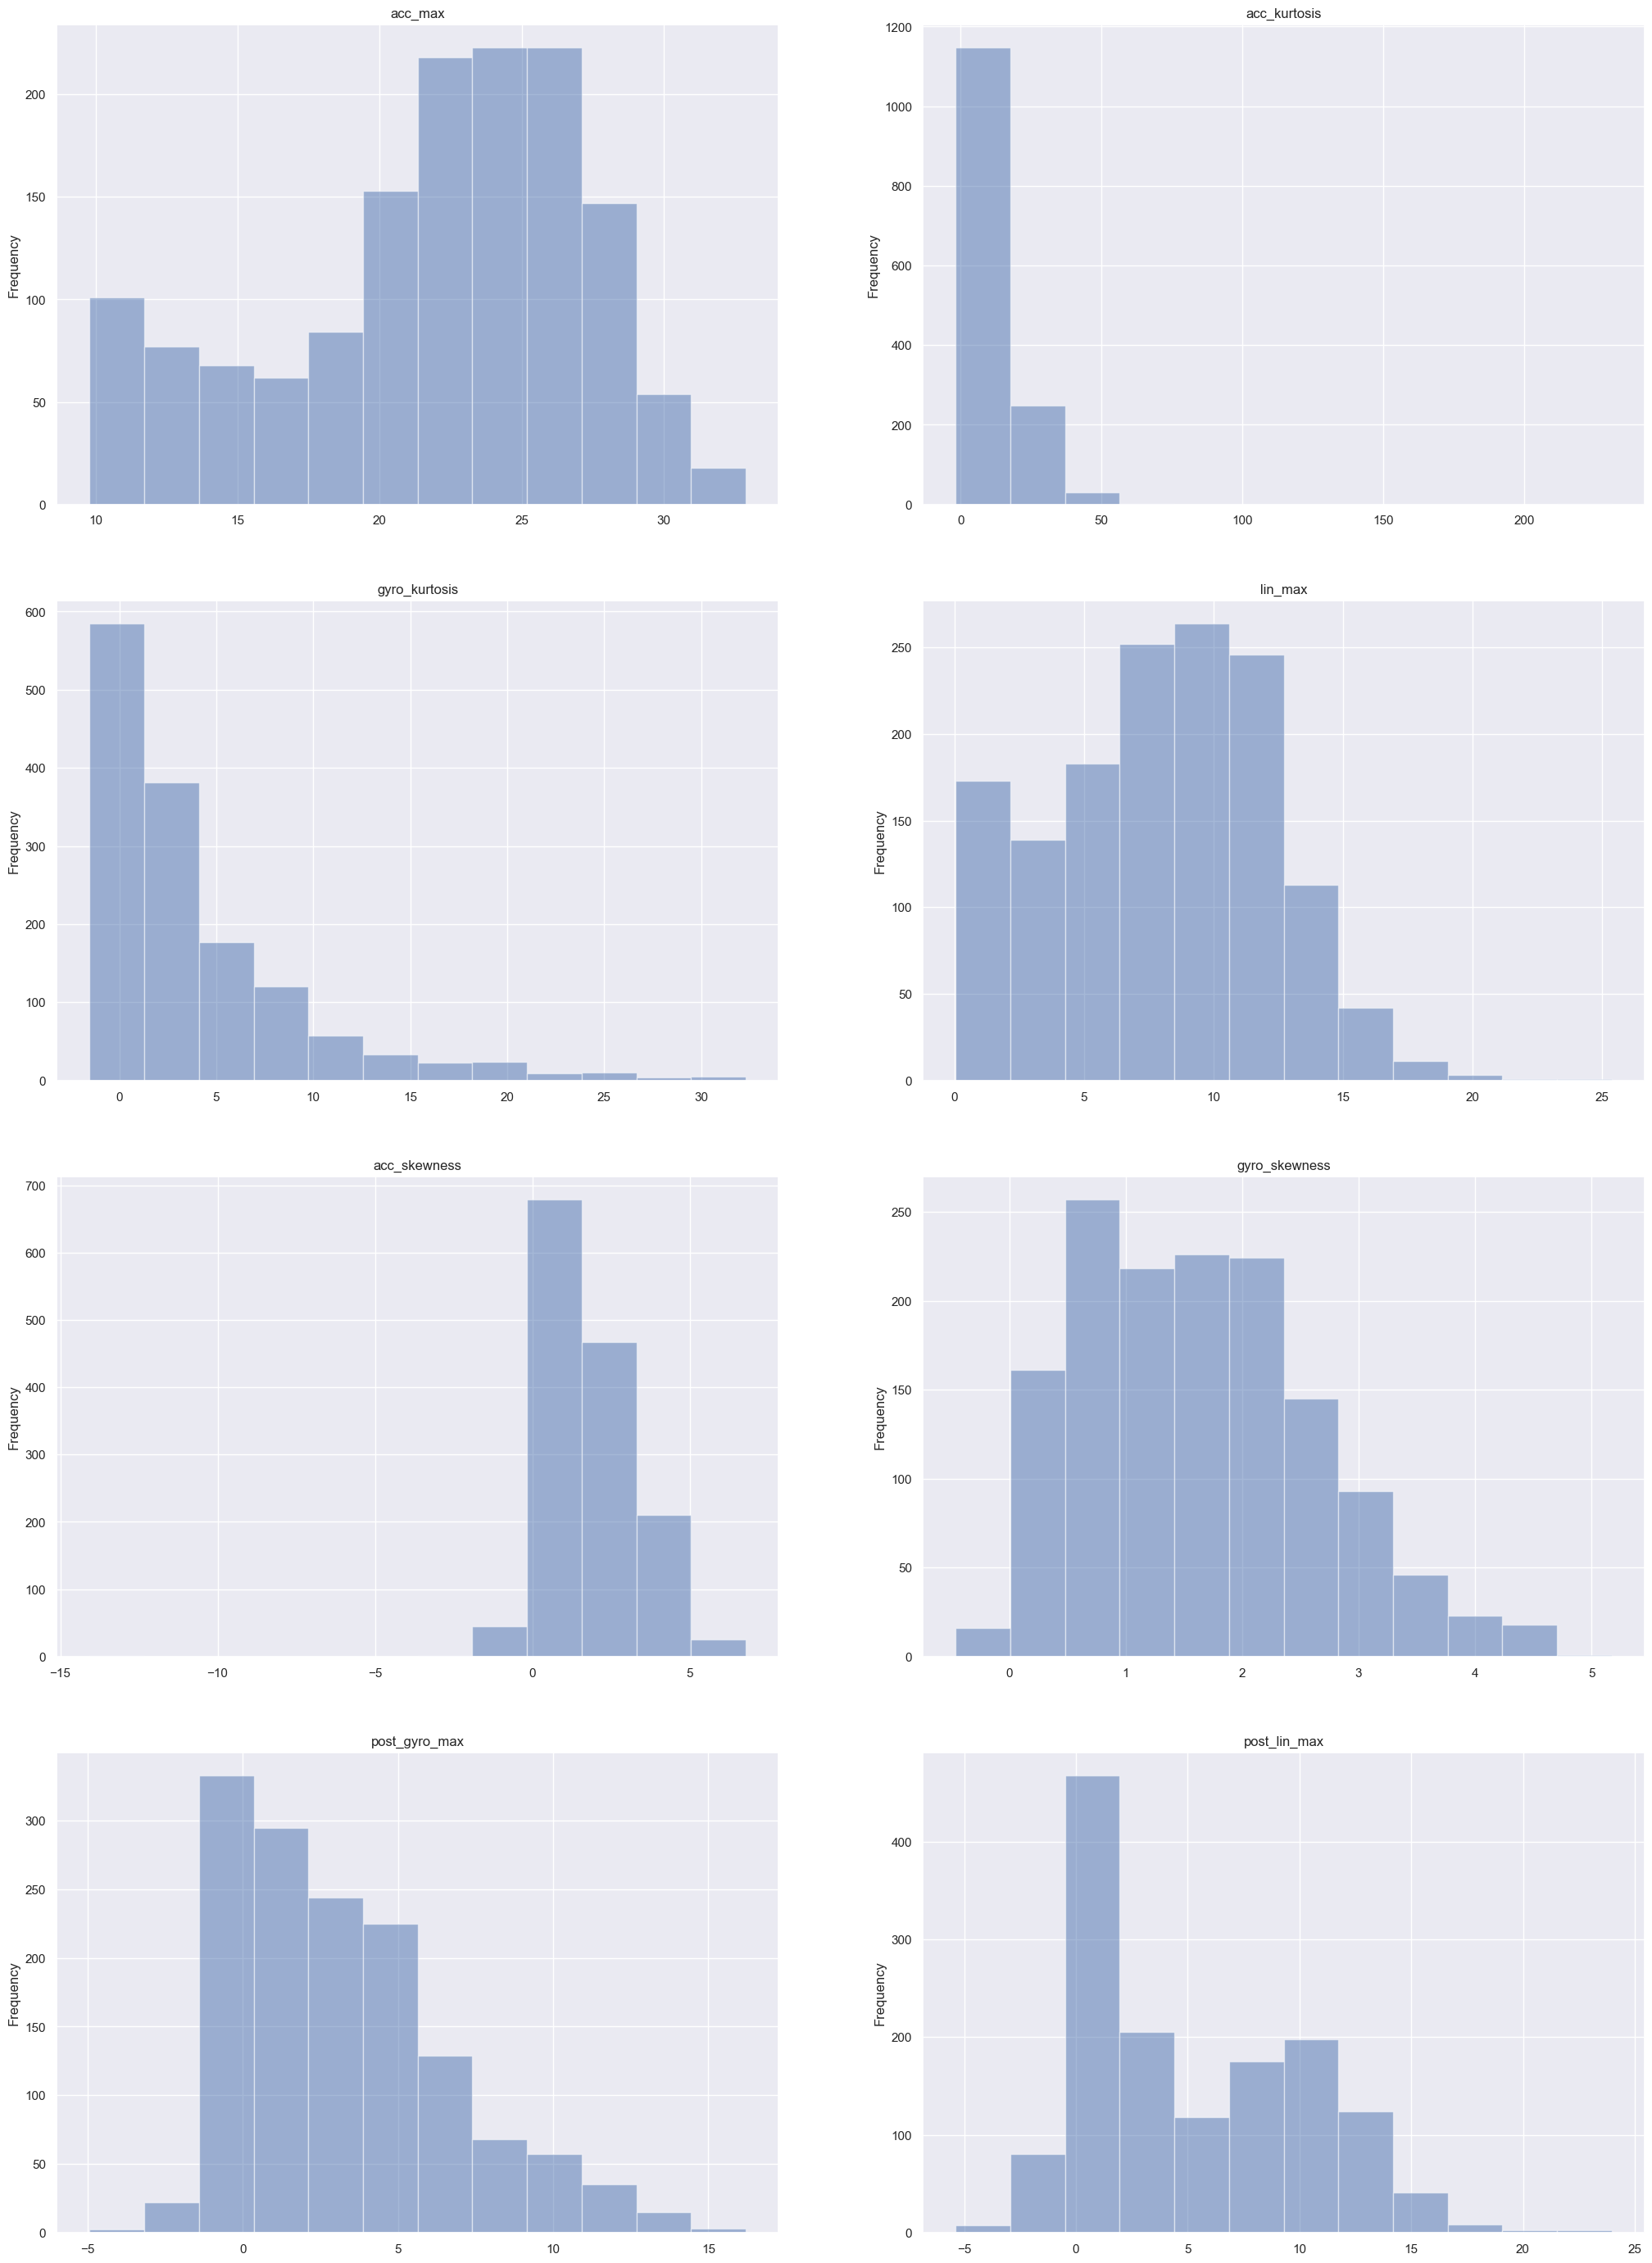

In [25]:
n_samples = X_train.shape[0]
n_features = X_train.shape[1]
figure, ax = plt.subplots(4,2, figsize=(25, 35))
i=0
j=0
for col in X_train.columns:
    ax[j][i].title.set_text(col)
    X_train[col].plot.hist(bins=12, alpha=0.5, ax = ax[j][i])
    i+=1
    if(i%2==0):
        j+=1
        i =0

## Observations:
* *acc_max*, *lin_max* and *acc_skewness* are **left skewed** (most of the data are concentrated on the right side of the distribution graph).
* *acc_kurtosis*, *gyro_kurtosis*, *post_gyro_max* and *gyro_skewness* are  **right skewed** (most of the data are concentrated on the left side of the distribution graph).
* *post_lin_max* has an almost **zero skew** (almost normal distribution of data).

We will use **Standard Scaler** to normalize our data.

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 5. Hyperparameter Tuning of Random Forest using Random Search

Hyperparameter tuning of Random Forest follows two stage:
1. We will a set of random values of the parameters are preset and a random combination of the parameter sets will be trained on 5-fold cross-validation. A technique called **Random Search** will be used to obtain the optimum parameter values. This stage promotes **exploration**.
2. In the second stage we will use the best parameter combination obtained from **Random Search** and search the solution space around that best value to find the most optimal combination of parameter value. This stage promotes **exploitation**.

## 5.1 Random Search
We will first preset a set of values for the parameters to train our *Random Forest*. We will use *Random Search* to search and find the best combination.

In [27]:
# Number of trees in random forest
n_estimators = [200,400,600,800,1000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [None,10,30,50,70]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 9, 12]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 3, 5, 7]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [None, 10, 30, 50, 70], 'min_samples_split': [2, 5, 9, 12], 'min_samples_leaf': [1, 3, 5, 7], 'bootstrap': [True, False]}


There are a total of 1600 combinations of the parameter values and it is very expensive to search through all of them to find the optimal solution. So we use *Random Search* to pick a random combination of parameter values and try our model on that.

In [28]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100, cv = 5,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1
                              )
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 30, 50, 70],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 5, 7],
                                        'min_samples_split': [2, 5, 9, 12],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000]},
                   random_state=42, verbose=2)

We print and see the best set of hyperparameter value combinations obtained using *Random Search*.

In [ ]:
rf_random.best_params_

In [ ]:
# Creating a function to evaluate our model
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = (((predictions==test_labels).sum())/test_labels.shape[0])*100
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy))

    return accuracy

In [ ]:
best_estimator = rf_random.best_estimator_
optimal_accuracy = evaluate(best_estimator, X_test, y_test)

## 5.2 Optimal Search
To search the solution space around that best value and find the most optimal combination of parameter value we will only make variations in two parameters which are *min_samples_split* and *min_samples_leaf*.

In [ ]:
params = rf_random.best_params_

min_split = [ 2, 4, 6, 8,12]
min_samples_leaf = [1, 2, 3, 4, 5]

x = []
y = []
acc = []
highest_accuracy = 0

for split in min_split:
    params['min_samples_split'] = split
    for leaf in min_samples_leaf:
        params['min_samples_leaf'] = leaf
        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train)
        accuracy = evaluate(model, X_test, y_test)
        acc.append(accuracy)
        x.append(split)
        y.append(leaf)
        highest_accuracy = max(highest_accuracy,accuracy)

In [ ]:
print(f"The highest accuracy obtained is: {highest_accuracy}%.")

We visualize this stage using a 3D plot.

In [29]:
#%matplotlib widget
# importing required libraries
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,8))
ax = Axes3D(fig)
accuracy_plot = ax.scatter(x, y, acc, color='red', cmap='Blues')

# setting title and labels
ax.set_title("3D plot of min_samples split, min_sample_leaf and accuracy")
ax.set_xlabel('min_samples_split')
ax.set_ylabel('min_sample_leaf')
ax.set_zlabel('Accuracy')
ax.set_zlim(96.8,97.5)
plt.show()

NameError: name 'x' is not defined

<Figure size 1600x800 with 0 Axes>

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=400; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=200; total time=   0.8s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000; total time=   3.7s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=7, min_samples_split=12, n_estimators=600; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=7, min_samples_split=12, n_estimators=600; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=7, min_samples_split=12, n_estimators=600; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=7, min_samples_split=12, n_estimators=600; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, 